<a href="https://colab.research.google.com/github/kashyab12/RAN-Slicing-Simulation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib
!pip install import_ipynb

Executing: /tmp/apt-key-gpghome.3FPGxvAepd/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [

In [55]:
# Cloning Repo and setting it as the working Directory
%cd /content/
!rm -r RAN-Slicing-Simulation
!git clone https://github.com/kashyab12/RAN-Slicing-Simulation.git
%cd RAN-Slicing-Simulation/

/content
Cloning into 'RAN-Slicing-Simulation'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 72 (delta 25), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (72/72), done.
/content/RAN-Slicing-Simulation


In [56]:
import import_ipynb
import Substrate as sbs
import RanSlice as rn
from graph_tool.all import *

In [57]:
# Initiailzing the Substrate Network

sbs.setSbsNetworkProperties()
sbs.createSbsTowers()
sbs.setSbsTowerProperties()
sbs.createSbsTowerConnections()

In [58]:
# Initiailzing the RAN Slices

rn.createRANSlices()
rn.setRANSliceProperties()
rn.createVNFFunctions()
rn.setVNFFunctionProperties()
rn.createVNFConnections()

In [59]:
# Initializing the total network.

totalNetwork = Graph(directed=False)
totalNetwork = graph_union(totalNetwork, sbs.substrateNetwork, include = True, internal_props=True)
totalNetwork = graph_union(totalNetwork, rn.ranSlices[0], include = True, internal_props=True)

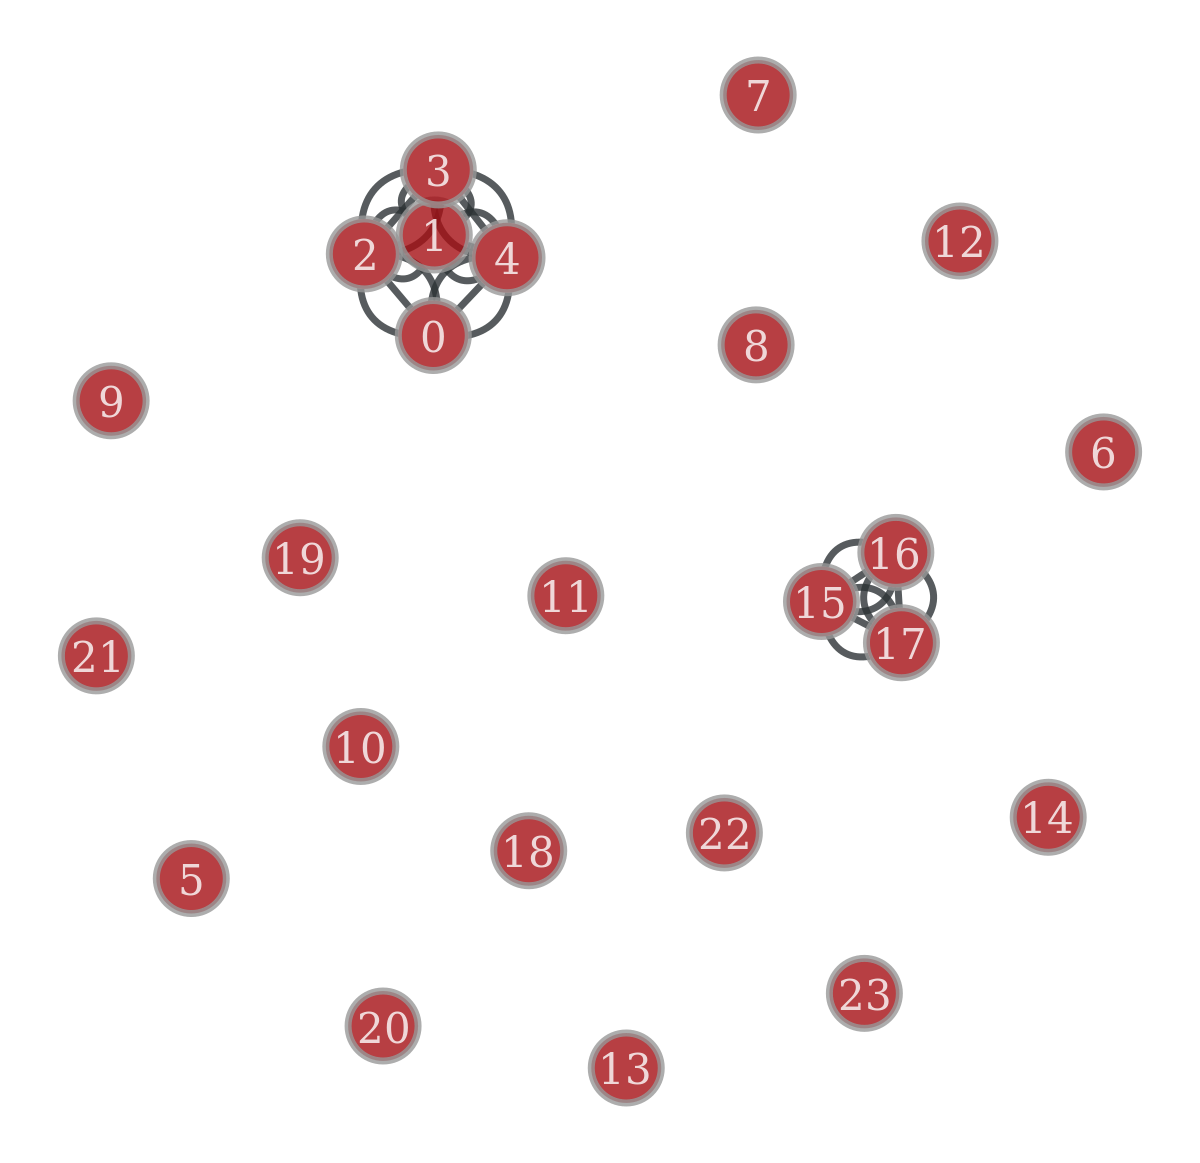

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7febcd86ff60, at 0x7febcd86f5c0>

In [60]:
# Testing the Created Network

graph_draw(totalNetwork, vertex_text = totalNetwork.vertex_index)

In [54]:
# 1) Algorithm One

# a) Sorting the VNF Function Resource Values in decreasing order
sortedResVal = sorted(rn.resList, reverse=True)

sbsSpecVertex = 0
rnSpecVertex = 0

# b) Iterating through the sorted array
for resourceValue in sortedResVal:

  foundSbsVert = False

  # c) Finding the vertex with the specified resource value
  rnSpecVertex = find_vertex(totalNetwork, totalNetwork.vertex_properties.resources, resourceValue)

  for foundVertex in rnSpecVertex:
    if totalNetwork.vertex_properties.binaryMappingVar[foundVertex] == 0:
      break
    else:
      rnSpecVertex.pop(0)

  if not rnSpecVertex:
    continue

  # c) Find the neighbors of the found vertex and iterate through them
  isNeighborMapped = False

  for mappedNeighbors in rnSpecVertex[0].all_neighbors():
    if totalNetwork.vertex_properties.binaryMappingVar[mappedNeighbors] == 1:
      isNeighborMapped = True
    else:
      continue
  
  if isNeighborMapped == False:

    # Trying to find the Optimal Network Tower to Connect to

    for towerVertex in totalNetwork.vertices():
      if totalNetwork.vertex_properties.resourceCapacity[towerVertex] >= resourceValue and totalNetwork.vertex_properties.resourceCapacity[towerVertex] >= 0:
        print("Reached the Loop")
        sbsSpecVertex = towerVertex
        foundSbsVert = True
        break
      else:
        continue

    # In this case we are not worring about the Bandwidth since none of the Neighbors are mapped

    # Proceeding futher with the actual Mapping of the VNF Function to the Substrate Tower

    if foundSbsVert == False:
      continue
    else:
      totalNetwork.add_edge(sbsSpecVertex, rnSpecVertex[0])
      totalNetwork.vertex_properties.binaryMappingVar[rnSpecVertex[0]] = 1
      totalNetwork.vertex_properties.resourceCapacity[sbsSpecVertex] -= totalNetwork.vertex_properties.resources[rnSpecVertex[0]]

  else:
    
    connectionList = []
    possibleSbsTowers = set()
    mappedNeighborVnfs = []
    correspondingSbsTowers = []
    isFirstIter = True

    # Iterating through the neighbors of the vnf vertex
    for vnf_vertex_neighbor in rnSpecVertex[0].all_neighbors():
      # Finding the Substrate Network of the mapped neighbour
      if totalNetwork.vertex_properties.binaryMappingVar[vnf_vertex_neighbor] == 1:

        mappedNeighborVnfs.append(vnf_vertex_neighbor)

        # Finding the corresponding substrate tower that the vnf was mapped to
        connectedSbsTower = find_edge(totalNetwork, totalNetwork.edge_properties.bandwidth, 0)

        #  Trying to find the substrate tower mapped by the vnf vertex
        for edges in connectedSbsTower:
          
          if edges.source() == vnf_vertex_neighbor:
            connectedSbsTower = edges.target()
            break

        # for substrate_tower in vnf_vertex_neighbor.all_neighbors():
        #   print("Reached the Loop")
        #   if totalNetwork.vertex_properties.resourceCapacity[substrate_tower] >= 0:
        #     connectedSbsTower = substrate_tower
        #     print("Found")
        #     break#

        # Adding the substrate tower and its neighbours to a list 
        correspondingSbsTowers.append(connectedSbsTower)

        connectionList.append(connectedSbsTower)
        connectionList.append(connectedSbsTower.all_neighbors())

        if isFirstIter == True:
          possibleSbsTowers = set.union(set(connectionList), possibleSbsTowers)
          isFirstIter = False
        else:
          possibleSbsTowers = set.intersection(set(connectionList), possibleSbsTowers)

        if not possibleSbsTowers:
          print("Failure (1 else)")
          break

    # Check if there are any substrate towers that exist
    if not possibleSbsTowers:
      print("Detected Failure (2 else)")
      continue
    else:
      foundSbsVert = True

      for sbsTowers in possibleSbsTowers:

        if totalNetwork.vertex_properties.resourceCapacity[sbsTowers] >= resourceValue:
    
          while idx < len(mappedNeighborVnfs):
            vnfEdge = 0 
            sbsEdge = 0

            for edge in rnSpecVertex[0].all_edges():
              if edge.target() == mappedNeighborVnfs[idx]:
                vnfEdge = edge
                break

            for edge in sbsTowers.all_edges():
              if edge.target() == correspondingSbsTowers[idx]:
                sbsEdge = edge
                break

            if totalNetwork.edge_properties.bandwidth[sbsEdge] >= totalNetwork.edge_properties.bandwidth[vnfEdge]:
              continue
            else:
              foundSbsVert = False
              break

        if foundSbsVert == True:
          sbsSpecVertex = sbsTowers
          break

    if foundSbsVert == False:
      print("Failure due to BandW or Resources (3 else)")
    else:
      totalNetwork.add_edge(sbsSpecVertex, rnSpecVertex[0])
      totalNetwork.vertex_properties.binaryMappingVar[rnSpecVertex[0]] = 1
      totalNetwork.vertex_properties.resourceCapacity[sbsSpecVertex] -= totalNetwork.vertex_properties.resources[rnSpecVertex[0]]
    




AttributeError: ignored

In [ ]:
graph_draw(totalNetwork, vertex_text = totalNetwork.vertex_properties.get("resourceCapacity"), edge_text = totalNetwork.edge_properties.get("bandwidth"))